In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

In [3]:
data = pd.read_csv('data/usyields.csv')
t = data['maturity'].to_numpy()

### Fit for a single date


In [4]:
y = data['2019-11-18']

In [5]:
curve, _ = calibrate_nss_ols(t, y)

In [7]:
t_cont = np.linspace(0, 30, 100)

In [9]:
fitted_curve = curve(t_cont)

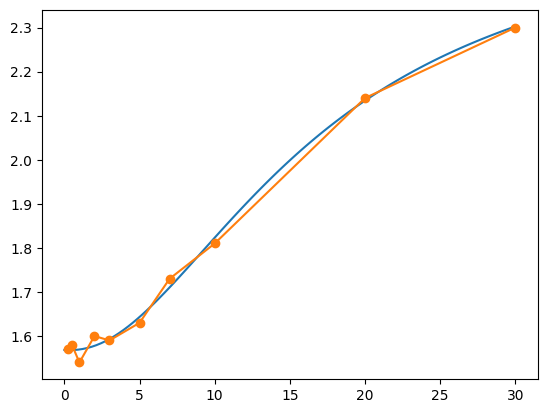

In [12]:
plt.plot(t_cont, fitted_curve)
plt.plot(t, y, '-o')